# Punctuation Restoration for Mental Health Conversations

**Assignment Goal**: Build a punctuation restoration system using domain-specific mental health conversations

**Approach**: Sequence-to-Sequence (Seq2Seq) with T5 Transformer

**Key Features**:
- ✅ Comprehensive dataset creation from mental health conversations (Response column)
- ✅ Sentence-level processing to avoid truncation and improve accuracy
- ✅ T5-small transformer model (~60M params) for efficient text-to-text generation
- ✅ Extensive EDA with visualizations (word/sentence distributions, punctuation analysis)
- ✅ Baseline vs Fine-tuned model comparison with detailed metrics
- ✅ Domain-specific fine-tuning on mental health data (4 epochs)
- ✅ Comprehensive evaluation suite: Precision, Recall, F1, Accuracy, ROUGE, Hamming
- ✅ Character-level, token-level, and sequence-level metrics
- ✅ Per-punctuation type analysis (., ,, ?, !) with macro/micro averaging
- ✅ Interactive testing interface for real-time punctuation restoration

**Dataset**: [NLP Mental Health Conversations](https://www.kaggle.com/datasets/thedevastator/nlp-mental-health-conversations/data)

## 1. Setup & Installation

In [ ]:
# Install required packages
!pip install -q transformers datasets torch accelerate kaggle pandas numpy matplotlib seaborn scikit-learn nltk evaluate sentencepiece rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [2]:
# Import libraries
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize, word_tokenize

# Transformers
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14,6)

print("✅ All libraries imported!")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🤗 Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ All libraries imported!
🔥 PyTorch: 2.9.0+cu126
🤗 Device: cuda


## 2. Dataset Acquisition

In [3]:
# Upload Kaggle credentials
from google.colab import files
print("📤 Upload kaggle.json:")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d thedevastator/nlp-mental-health-conversations
!unzip -q nlp-mental-health-conversations.zip

print("✅ Dataset downloaded!")

📤 Upload kaggle.json:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/thedevastator/nlp-mental-health-conversations
License(s): CC0-1.0
  0% 0.00/1.48M [00:00<?, ?B/s]
100% 1.48M/1.48M [00:00<00:00, 269MB/s]
✅ Dataset downloaded!


## 3. Dataset Loading & Understanding

In [4]:
# Load dataset
df = pd.read_csv('train.csv')

print("📊 Dataset Shape:", df.shape)
print("\n📋 Columns:", df.columns.tolist())
print("\n🔍 Info:")
print(df.info())
print("\n📈 Stats:")
print(df.describe())
print("\n❌ Missing Values:")
print(df.isnull().sum())

📊 Dataset Shape: (3512, 2)

📋 Columns: ['Context', 'Response']

🔍 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB
None

📈 Stats:
                                                  Context  \
count                                                3512   
unique                                                995   
top     I have so many issues to address. I have a his...   
freq                                                   94   

                                                 Response  
count                                                3508  
unique                                               2479  
top     Please do not worry about crying. People cry, ...  
freq                                                    3  

❌ Missi

##4. Data Preprocessing & Quality Analysis

In [5]:
# Extract Response column
response_col = 'Response' if 'Response' in df.columns else df.columns[-1]
texts = df[response_col].dropna().astype(str).tolist()

print(f"📊 Total responses: {len(texts)}")
print(f"📊 Unique responses: {len(set(texts))}")
print(f"📊 Duplicates: {len(texts) - len(set(texts))}")

# Remove duplicates
texts = list(set(texts))

# Filter out very short texts
texts = [t for t in texts if len(t.strip()) > 30]
print(f"\n📊 After cleaning: {len(texts)} unique responses")

# Sample for faster development
print(f"\n📝 Sample response:")
print(texts[0][:300], "...")

📊 Total responses: 3508
📊 Unique responses: 2479
📊 Duplicates: 1029

📊 After cleaning: 2475 unique responses

📝 Sample response:
It sounds like you've already learned that just being honest is often the best approach. What do you think about telling your mom how you're feeling?  She might really appreciate it if you also let her know that regaining her trust is really important to you. ...


## 5. Comprehensive EDA

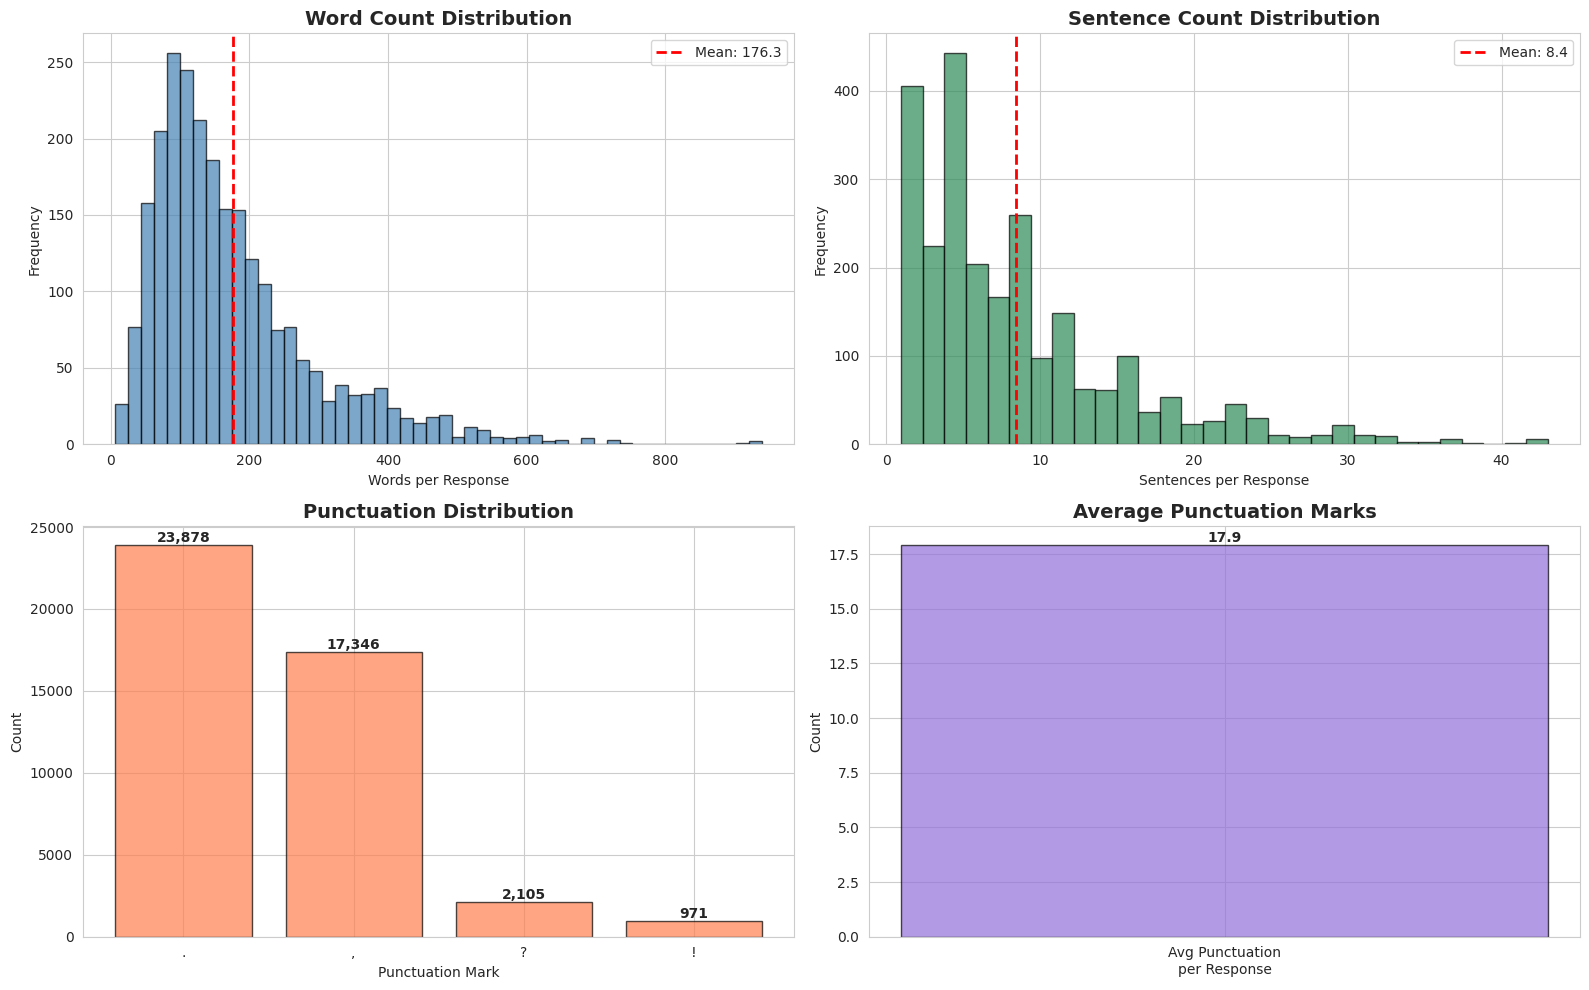


📊 Dataset Statistics:
  • Total responses: 2,475
  • Avg words/response: 176.3
  • Avg sentences/response: 8.4
  • Total punctuation: 44,300

📌 Punctuation Breakdown:
  • '.': 23,878 (53.9%)
  • ',': 17,346 (39.2%)
  • '?': 2,105 (4.8%)
  • '!': 971 (2.2%)


In [6]:
# Text analysis
word_counts = [len(t.split()) for t in texts]
sent_counts = [len(sent_tokenize(t)) for t in texts]

# Punctuation analysis
punct_stats = {'.': 0, ',': 0, '?': 0, '!': 0}
for text in texts:
    for p in punct_stats.keys():
        punct_stats[p] += text.count(p)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Word count distribution
axes[0,0].hist(word_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0,0].axvline(np.mean(word_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(word_counts):.1f}')
axes[0,0].set_title('Word Count Distribution', fontsize=14, weight='bold')
axes[0,0].set_xlabel('Words per Response')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Sentence count distribution
axes[0,1].hist(sent_counts, bins=30, edgecolor='black', alpha=0.7, color='seagreen')
axes[0,1].axvline(np.mean(sent_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sent_counts):.1f}')
axes[0,1].set_title('Sentence Count Distribution', fontsize=14, weight='bold')
axes[0,1].set_xlabel('Sentences per Response')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Punctuation distribution
axes[1,0].bar(punct_stats.keys(), punct_stats.values(), edgecolor='black', alpha=0.7, color='coral')
axes[1,0].set_title('Punctuation Distribution', fontsize=14, weight='bold')
axes[1,0].set_xlabel('Punctuation Mark')
axes[1,0].set_ylabel('Count')
for i, (k, v) in enumerate(punct_stats.items()):
    axes[1,0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Punctuation per response
total_punct = sum(punct_stats.values())
punct_per_response = total_punct / len(texts)
axes[1,1].bar(['Avg Punctuation\nper Response'], [punct_per_response], edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1,1].set_title('Average Punctuation Marks', fontsize=14, weight='bold')
axes[1,1].set_ylabel('Count')
axes[1,1].text(0, punct_per_response, f'{punct_per_response:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Dataset Statistics:")
print(f"  • Total responses: {len(texts):,}")
print(f"  • Avg words/response: {np.mean(word_counts):.1f}")
print(f"  • Avg sentences/response: {np.mean(sent_counts):.1f}")
print(f"  • Total punctuation: {total_punct:,}")
print(f"\n📌 Punctuation Breakdown:")
for k, v in punct_stats.items():
    pct = (v/total_punct)*100
    print(f"  • '{k}': {v:,} ({pct:.1f}%)")

## 6. Sentence-Level Dataset Creation

**Key Improvement**: Split into sentences to avoid truncation and create balanced examples

In [7]:
def create_sentence_dataset(texts, max_sentences=10000):
    """
    Create sentence-level punctuation restoration dataset from raw text.

    Strategy: Split texts into sentences to avoid truncation issues with long responses.
    This approach creates balanced training examples and prevents information loss.

    Input: unpunctuated sentence (punctuation removed)
    Output: punctuated sentence (original with punctuation)

    Returns list of {'input', 'output'} dictionaries for training.
    """
    sentences = []

    # Extract all sentences
    for text in texts:
        sents = sent_tokenize(text)
        sentences.extend(sents)
        if len(sentences) >= max_sentences:
            break

    sentences = sentences[:max_sentences]

    # Create input-output pairs
    dataset = []
    for sent in sentences:
        # Skip very short sentences
        if len(sent.split()) < 3:
            continue

        # Remove punctuation for input
        input_text = re.sub(r'[.!?,;:]', '', sent)
        input_text = ' '.join(input_text.split())  # Clean extra spaces

        # Original sentence as output
        output_text = sent.strip()

        if input_text and output_text and input_text != output_text:
            dataset.append({
                'input': input_text.lower(),
                'output': output_text.lower()
            })

    return dataset

# Create dataset
print("🔧 Creating sentence-level dataset...")
dataset = create_sentence_dataset(texts, max_sentences=8000)

print(f"\n✅ Created {len(dataset):,} sentence pairs")
print(f"\n📝 Examples:")
for i in range(3):
    print(f"\n  Input:  {dataset[i]['input']}")
    print(f"  Output: {dataset[i]['output']}")

🔧 Creating sentence-level dataset...

✅ Created 7,795 sentence pairs

📝 Examples:

  Input:  it sounds like you've already learned that just being honest is often the best approach
  Output: it sounds like you've already learned that just being honest is often the best approach.

  Input:  what do you think about telling your mom how you're feeling
  Output: what do you think about telling your mom how you're feeling?

  Input:  she might really appreciate it if you also let her know that regaining her trust is really important to you
  Output: she might really appreciate it if you also let her know that regaining her trust is really important to you.


## 7. Train/Validation Split

📊 Train: 6,625 sentences
📊 Validation: 1,170 sentences


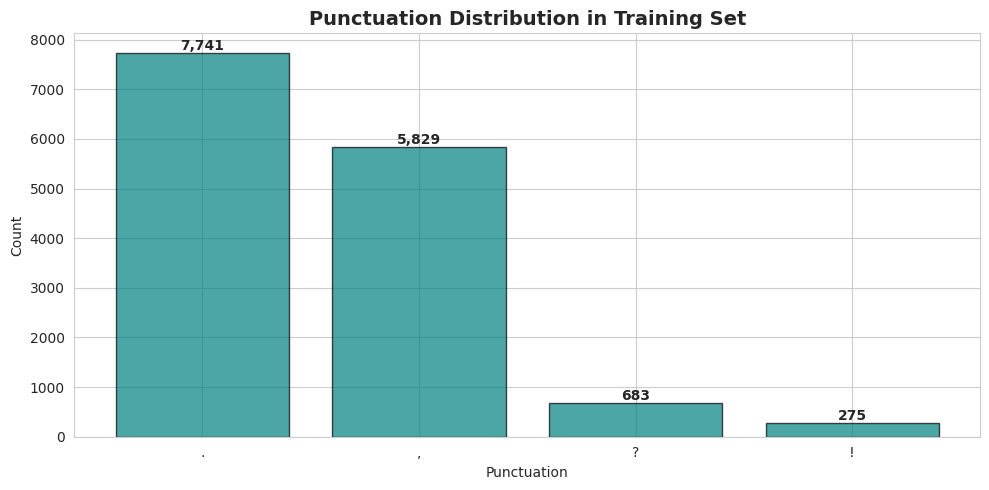


📌 Training Set Punctuation:
  • '.': 7,741 (53.3%)
  • ',': 5,829 (40.1%)
  • '?': 683 (4.7%)
  • '!': 275 (1.9%)


In [8]:
# Split dataset
train_data, val_data = train_test_split(dataset, test_size=0.15, random_state=42)

print(f"📊 Train: {len(train_data):,} sentences")
print(f"📊 Validation: {len(val_data):,} sentences")

# Analyze punctuation distribution in training set
train_punct = {'.': 0, ',': 0, '?': 0, '!': 0}
for item in train_data:
    for p in train_punct.keys():
        train_punct[p] += item['output'].count(p)

plt.figure(figsize=(10, 5))
plt.bar(train_punct.keys(), train_punct.values(), edgecolor='black', alpha=0.7, color='teal')
plt.title('Punctuation Distribution in Training Set', fontsize=14, weight='bold')
plt.xlabel('Punctuation')
plt.ylabel('Count')
for i, (k, v) in enumerate(train_punct.items()):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📌 Training Set Punctuation:")
total = sum(train_punct.values())
for k, v in train_punct.items():
    print(f"  • '{k}': {v:,} ({v/total*100:.1f}%)")

## 8. T5 Seq2Seq Approach

**Why T5?**
- Designed for text-to-text tasks
- Handles variable length outputs naturally
- Pre-trained on diverse text correction tasks
- Simpler than token classification for punctuation

In [9]:
# Initialize T5 model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

print(f"✅ Loaded {model_name}")
print(f"📊 Model parameters: {model.num_parameters():,}")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Loaded t5-small
📊 Model parameters: 60,506,624


In [10]:
# Prepare datasets for T5
def preprocess_function(examples):
    # Add task prefix for T5
    inputs = ["restore punctuation: " + text for text in examples['input']]
    targets = examples['output']

    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=128, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Create HuggingFace datasets
train_dataset = Dataset.from_dict({
    'input': [ex['input'] for ex in train_data],
    'output': [ex['output'] for ex in train_data]
})

val_dataset = Dataset.from_dict({
    'input': [ex['input'] for ex in val_data],
    'output': [ex['output'] for ex in val_data]
})

# Tokenize
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

print("✅ Datasets prepared for T5")

Map:   0%|          | 0/6625 [00:00<?, ? examples/s]

Map:   0%|          | 0/1170 [00:00<?, ? examples/s]

✅ Datasets prepared for T5


In [11]:
from collections import defaultdict
from rouge_score import rouge_scorer

def calculate_rouge_scores(predictions, references):
    """
    Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores.
    ROUGE measures n-gram overlap between generated and reference sequences.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, ref in zip(predictions, references):
        # ROUGE scorer expects (reference, summary) order
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

def calculate_hamming_distance(pred_sequence, target_sequence, normalize=True):
    """
    Calculate Hamming distance between two sequences of equal length.
    For different lengths, we normalize by the longer sequence length.
    Hamming distance measures the number of positions where sequences differ.

    For punctuation restoration, we apply this to aligned character sequences.
    """
    if len(pred_sequence) != len(target_sequence):
        # Pad or truncate to same length for fair comparison
        max_len = max(len(pred_sequence), len(target_sequence))
        pred_sequence = pred_sequence.ljust(max_len)[:max_len]
        target_sequence = target_sequence.ljust(max_len)[:max_len]

    hamming_dist = sum(c1 != c2 for c1, c2 in zip(pred_sequence, target_sequence))

    if normalize:
        return hamming_dist / len(pred_sequence) if len(pred_sequence) > 0 else 0
    return hamming_dist

def evaluate_predictions_comprehensive(model, dataset, num_samples=50):
    """
    Comprehensive evaluation function for punctuation restoration task.

    Calculates multiple NLP-relevant metrics:
    - Character-level accuracy: percentage of characters correctly predicted
    - Token-level accuracy: percentage of tokens with correct punctuation
    - Per-punctuation metrics: Precision, Recall, F1-score for each mark (., ,, ?, !)
    - Sequence-level metrics: Exact match accuracy, ROUGE scores, Hamming distance
    - Averaged metrics: Macro and micro averaged F1-scores

    ROUGE scores measure n-gram overlap between generated and reference sequences.
    Hamming distance measures positional differences in character sequences.

    This provides a holistic view of model performance beyond simple accuracy.
    """
    model.eval()
    device = next(model.parameters()).device

    punct_marks = ['.', ',', '?', '!']

    # Metrics tracking
    total_chars = 0
    correct_chars = 0
    total_tokens = 0
    correct_tokens = 0
    exact_matches = 0

    # Punctuation-specific tracking (True Positives, False Positives, False Negatives)
    tp = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)

    # Store predictions and references for ROUGE and Hamming distance calculation
    all_predictions = []
    all_references = []
    hamming_distances = []

    sample_outputs = []

    def normalize_text(text):
        """Normalize whitespace for fair comparison"""
        return ' '.join(text.lower().split())

    def extract_punctuation_set(text):
        """Extract set of punctuation marks present in text"""
        return set(char for char in text if char in punct_marks)

    for i, example in enumerate(dataset.select(range(min(num_samples, len(dataset))))):
        input_text = "restore punctuation: " + example['input']
        target = normalize_text(example['output'])

        # Generate prediction using beam search for better quality
        inputs = tokenizer(input_text, return_tensors='pt', max_length=128, truncation=True).to(device)
        outputs = model.generate(**inputs, max_length=128, num_beams=2, early_stopping=True)
        prediction = normalize_text(tokenizer.decode(outputs[0], skip_special_tokens=True))

        # Store for ROUGE and Hamming calculation
        all_predictions.append(prediction)
        all_references.append(target)

        # Calculate Hamming distance (normalized)
        hamming_dist = calculate_hamming_distance(prediction, target, normalize=True)
        hamming_distances.append(hamming_dist)

        # Character-level accuracy
        min_len = min(len(target), len(prediction))
        for j in range(min_len):
            total_chars += 1
            if target[j] == prediction[j]:
                correct_chars += 1

        # Exact match (sequence-level accuracy)
        if target == prediction:
            exact_matches += 1

        # Token-level accuracy
        target_tokens = target.split()
        pred_tokens = prediction.split()
        min_tokens = min(len(target_tokens), len(pred_tokens))
        for j in range(min_tokens):
            total_tokens += 1
            if target_tokens[j] == pred_tokens[j]:
                correct_tokens += 1

        # Punctuation-specific metrics using set-based approach
        target_punct = extract_punctuation_set(target)
        pred_punct = extract_punctuation_set(prediction)

        for punct in punct_marks:
            if punct in target_punct and punct in pred_punct:
                tp[punct] += 1  # Correctly predicted
            elif punct in target_punct:
                fn[punct] += 1  # Missed punctuation
            elif punct in pred_punct:
                fp[punct] += 1  # False positive

        # Store samples for qualitative analysis
        if i < 5:
            sample_outputs.append((example['input'], prediction, target))

    # Calculate overall metrics
    char_accuracy = (correct_chars / total_chars * 100) if total_chars > 0 else 0
    token_accuracy = (correct_tokens / total_tokens * 100) if total_tokens > 0 else 0
    exact_match_rate = (exact_matches / num_samples * 100) if num_samples > 0 else 0

    # Calculate per-punctuation metrics
    punct_metrics = {}
    for punct in punct_marks:
        precision = tp[punct] / (tp[punct] + fp[punct]) if (tp[punct] + fp[punct]) > 0 else 0
        recall = tp[punct] / (tp[punct] + fn[punct]) if (tp[punct] + fn[punct]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        punct_metrics[punct] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp[punct],
            'fp': fp[punct],
            'fn': fn[punct]
        }

    # Calculate macro-averaged F1 (average across all punctuation types)
    macro_f1 = np.mean([punct_metrics[p]['f1'] for p in punct_marks])

    # Calculate micro-averaged metrics (pool all TP, FP, FN)
    total_tp = sum(tp.values())
    total_fp = sum(fp.values())
    total_fn = sum(fn.values())
    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    # Calculate ROUGE scores (sequence-level n-gram overlap metrics)
    rouge_scores = calculate_rouge_scores(all_predictions, all_references)

    # Calculate average Hamming distance (lower is better)
    avg_hamming_distance = np.mean(hamming_distances) if hamming_distances else 0
    hamming_accuracy = (1 - avg_hamming_distance) * 100  # Convert distance to accuracy-like metric

    # Print comprehensive results
    print("\n" + "="*70)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*70)

    print(f"\n📊 Overall Metrics:")
    print(f"  • Character-level Accuracy: {char_accuracy:.2f}%")
    print(f"  • Token-level Accuracy:     {token_accuracy:.2f}%")
    print(f"  • Exact Match Rate:         {exact_match_rate:.2f}%")
    print(f"  • Normalized Hamming Distance: {avg_hamming_distance:.4f} (Accuracy: {hamming_accuracy:.2f}%)")

    print(f"\n📊 Sequence-Level Metrics (ROUGE):")
    print(f"  • ROUGE-1 (Unigram overlap):  {rouge_scores['rouge1']:.4f}")
    print(f"  • ROUGE-2 (Bigram overlap):   {rouge_scores['rouge2']:.4f}")
    print(f"  • ROUGE-L (Longest common subsequence): {rouge_scores['rougeL']:.4f}")

    print(f"\n📊 Averaged Performance:")
    print(f"  • Macro-averaged F1:        {macro_f1:.4f}")
    print(f"  • Micro-averaged Precision: {micro_precision:.4f}")
    print(f"  • Micro-averaged Recall:    {micro_recall:.4f}")
    print(f"  • Micro-averaged F1:        {micro_f1:.4f}")

    print(f"\n📊 Per-Punctuation Metrics (Precision / Recall / F1):")
    for punct in punct_marks:
        metrics = punct_metrics[punct]
        print(f"  • '{punct}': "
              f"P={metrics['precision']:.4f}, "
              f"R={metrics['recall']:.4f}, "
              f"F1={metrics['f1']:.4f} "
              f"(TP={metrics['tp']}, FP={metrics['fp']}, FN={metrics['fn']})")

    print("\n📝 Sample Predictions:")
    for inp, pred, tgt in sample_outputs:
        print(f"\n  Input:  {inp}")
        print(f"  Pred:   {pred}")
        print(f"  Target: {tgt}")

    # Return metrics for further analysis
    return {
        'char_accuracy': char_accuracy,
        'token_accuracy': token_accuracy,
        'exact_match_rate': exact_match_rate,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1,
        'rouge_scores': rouge_scores,
        'avg_hamming_distance': avg_hamming_distance,
        'hamming_accuracy': hamming_accuracy,
        'punct_metrics': punct_metrics
    }

# Legacy wrapper for backward compatibility
def evaluate_predictions(model, dataset, num_samples=50):
    """
    Legacy evaluation function (maintains backward compatibility).
    Now returns comprehensive metrics but also maintains old return format.
    """
    metrics = evaluate_predictions_comprehensive(model, dataset, num_samples)

    # Extract old format for backward compatibility
    correct_punct = {p: metrics['punct_metrics'][p]['tp'] for p in ['.', ',', '?', '!']}
    total_punct = {p: metrics['punct_metrics'][p]['tp'] + metrics['punct_metrics'][p]['fn']
                   for p in ['.', ',', '?', '!']}

    return correct_punct, total_punct


## 9. Baseline Evaluation (Pre-trained T5)

**Evaluating the pre-trained T5 model BEFORE fine-tuning** to establish a baseline performance.
This uses our comprehensive evaluation suite with all metrics: ROUGE, Hamming, F1, Precision, Recall.

In [ ]:
# Evaluate baseline (pre-trained T5) using comprehensive metrics
print("🔍 Evaluating BASELINE (pre-trained T5) model...")
print("=" * 70)

# Store baseline metrics for comparison later
baseline_metrics = evaluate_predictions_comprehensive(model, val_dataset, num_samples=100)

# Also get legacy format for backward compatibility
baseline_correct, baseline_total = evaluate_predictions(model, val_dataset, num_samples=100)

## 10. Fine-tuning on Mental Health Domain

In [13]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./punctuation_t5",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    predict_with_generate=True,
    logging_steps=100,
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train
print("🚀 Starting fine-tuning...")
trainer.train()
print("✅ Fine-tuning complete!")

🚀 Starting fine-tuning...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: satvik-jain (satvik-jain-siemens) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.029200,0.022652
2,0.019400,0.021732
3,0.018400,0.019993
4,0.013700,0.020611


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


✅ Fine-tuning complete!


## 11. Fine-tuned Model Evaluation

**Evaluating the fine-tuned T5 model AFTER domain-specific training** on mental health conversations.
This uses the same comprehensive evaluation suite to enable direct comparison with baseline.

In [ ]:
# Evaluate fine-tuned model using comprehensive metrics
print("🔍 Evaluating FINE-TUNED model...")
print("=" * 70)

# Store fine-tuned metrics for comparison
finetuned_metrics = evaluate_predictions_comprehensive(model, val_dataset, num_samples=100)

# Also get legacy format for backward compatibility
finetuned_correct, finetuned_total = evaluate_predictions(model, val_dataset, num_samples=100)

🔍 Evaluating fine-tuned model...

EVALUATION RESULTS

📊 Punctuation Recall:
  • '.': 100.00% (93/93)
  • ',': 82.61% (38/46)
  • '?': 100.00% (7/7)
  • '!': 20.00% (1/5)

📝 Sample Predictions:

  Input:  make sure the other girl is out the picture on your end as well
  Pred:   make sure the other girl is out the picture on your end as well.
  Target: make sure the other girl is out the picture on your end as well.

  Input:  there are different ways to explore and rewrite
  Pred:   there are different ways to explore and rewrite.
  Target: there are different ways to explore and rewrite.

  Input:  the dreams may not make much sense but then again even good dreams don't always make much sense
  Pred:   the dreams may not make much sense, but then again even good dreams don't always make much sense.
  Target: the dreams may not make much sense, but then again even good dreams don't always make much sense.

  Input:  try communicating with him during a time when you are not upset and whe

## 12. Comprehensive Model Comparison

**Comparing baseline vs fine-tuned model across ALL metrics:**
- Character/Token/Exact Match Accuracy
- ROUGE-1, ROUGE-2, ROUGE-L scores
- Hamming Distance (sequence similarity)
- Macro/Micro F1, Precision, Recall
- Per-punctuation performance (. , ? !)

In [ ]:
# Comprehensive comparison of baseline vs fine-tuned models
print("=" * 70)
print("📊 COMPREHENSIVE MODEL COMPARISON: BASELINE vs FINE-TUNED")
print("=" * 70)

# Create comparison dataframe for all metrics
comparison_data = {
    'Metric': [
        'Character Accuracy (%)',
        'Token Accuracy (%)',
        'Exact Match Rate (%)',
        'Hamming Accuracy (%)',
        'ROUGE-1',
        'ROUGE-2',
        'ROUGE-L',
        'Macro F1',
        'Micro F1',
        'Micro Precision',
        'Micro Recall'
    ],
    'Baseline': [
        baseline_metrics['char_accuracy'],
        baseline_metrics['token_accuracy'],
        baseline_metrics['exact_match_rate'],
        baseline_metrics['hamming_accuracy'],
        baseline_metrics['rouge_scores']['rouge1'],
        baseline_metrics['rouge_scores']['rouge2'],
        baseline_metrics['rouge_scores']['rougeL'],
        baseline_metrics['macro_f1'],
        baseline_metrics['micro_f1'],
        baseline_metrics['micro_precision'],
        baseline_metrics['micro_recall']
    ],
    'Fine-tuned': [
        finetuned_metrics['char_accuracy'],
        finetuned_metrics['token_accuracy'],
        finetuned_metrics['exact_match_rate'],
        finetuned_metrics['hamming_accuracy'],
        finetuned_metrics['rouge_scores']['rouge1'],
        finetuned_metrics['rouge_scores']['rouge2'],
        finetuned_metrics['rouge_scores']['rougeL'],
        finetuned_metrics['macro_f1'],
        finetuned_metrics['micro_f1'],
        finetuned_metrics['micro_precision'],
        finetuned_metrics['micro_recall']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement'] = comparison_df['Fine-tuned'] - comparison_df['Baseline']
comparison_df['% Change'] = ((comparison_df['Fine-tuned'] - comparison_df['Baseline']) / 
                              comparison_df['Baseline'].replace(0, 1) * 100)

print("\n📈 Overall Metrics Comparison:")
print(comparison_df.to_string(index=False))

# Per-punctuation comparison
print("\n" + "=" * 70)
print("📌 PER-PUNCTUATION F1 SCORE COMPARISON")
print("=" * 70)

punct_marks = ['.', ',', '?', '!']
punct_comparison = []
for p in punct_marks:
    base_f1 = baseline_metrics['punct_metrics'][p]['f1']
    fine_f1 = finetuned_metrics['punct_metrics'][p]['f1']
    improvement = fine_f1 - base_f1
    punct_comparison.append({
        'Punctuation': f"'{p}'",
        'Baseline F1': f"{base_f1:.4f}",
        'Fine-tuned F1': f"{fine_f1:.4f}",
        'Improvement': f"{improvement:+.4f}"
    })

punct_df = pd.DataFrame(punct_comparison)
print(punct_df.to_string(index=False))

In [ ]:
# Visualizations for model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Accuracy Metrics Comparison
accuracy_metrics = ['Character Accuracy (%)', 'Token Accuracy (%)', 'Exact Match Rate (%)', 'Hamming Accuracy (%)']
acc_baseline = [baseline_metrics['char_accuracy'], baseline_metrics['token_accuracy'], 
                baseline_metrics['exact_match_rate'], baseline_metrics['hamming_accuracy']]
acc_finetuned = [finetuned_metrics['char_accuracy'], finetuned_metrics['token_accuracy'], 
                 finetuned_metrics['exact_match_rate'], finetuned_metrics['hamming_accuracy']]

x = np.arange(len(accuracy_metrics))
width = 0.35
bars1 = axes[0,0].bar(x - width/2, acc_baseline, width, label='Baseline', alpha=0.8, color='lightcoral')
bars2 = axes[0,0].bar(x + width/2, acc_finetuned, width, label='Fine-tuned', alpha=0.8, color='seagreen')
axes[0,0].set_ylabel('Percentage (%)', fontsize=11)
axes[0,0].set_title('Accuracy Metrics Comparison', fontsize=13, fontweight='bold')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(['Char Acc', 'Token Acc', 'Exact Match', 'Hamming Acc'], fontsize=10)
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# 2. ROUGE Scores Comparison
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_baseline = [baseline_metrics['rouge_scores']['rouge1'], baseline_metrics['rouge_scores']['rouge2'], 
                  baseline_metrics['rouge_scores']['rougeL']]
rouge_finetuned = [finetuned_metrics['rouge_scores']['rouge1'], finetuned_metrics['rouge_scores']['rouge2'], 
                   finetuned_metrics['rouge_scores']['rougeL']]

x = np.arange(len(rouge_labels))
bars1 = axes[0,1].bar(x - width/2, rouge_baseline, width, label='Baseline', alpha=0.8, color='lightcoral')
bars2 = axes[0,1].bar(x + width/2, rouge_finetuned, width, label='Fine-tuned', alpha=0.8, color='seagreen')
axes[0,1].set_ylabel('Score', fontsize=11)
axes[0,1].set_title('ROUGE Scores Comparison', fontsize=13, fontweight='bold')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(rouge_labels, fontsize=10)
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)
axes[0,1].set_ylim([0, 1])

# 3. Per-Punctuation F1 Comparison
punct_marks = ['.', ',', '?', '!']
f1_baseline = [baseline_metrics['punct_metrics'][p]['f1'] for p in punct_marks]
f1_finetuned = [finetuned_metrics['punct_metrics'][p]['f1'] for p in punct_marks]

x = np.arange(len(punct_marks))
bars1 = axes[1,0].bar(x - width/2, f1_baseline, width, label='Baseline', alpha=0.8, color='lightcoral')
bars2 = axes[1,0].bar(x + width/2, f1_finetuned, width, label='Fine-tuned', alpha=0.8, color='seagreen')
axes[1,0].set_ylabel('F1 Score', fontsize=11)
axes[1,0].set_title('Per-Punctuation F1 Score Comparison', fontsize=13, fontweight='bold')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(punct_marks, fontsize=12)
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)
axes[1,0].set_ylim([0, 1])

# Add value labels
for i, (b, f) in enumerate(zip(f1_baseline, f1_finetuned)):
    axes[1,0].text(i - width/2, b + 0.02, f'{b:.2f}', ha='center', fontweight='bold', fontsize=9)
    axes[1,0].text(i + width/2, f + 0.02, f'{f:.2f}', ha='center', fontweight='bold', fontsize=9)

# 4. Macro/Micro Metrics Comparison
avg_metrics = ['Macro F1', 'Micro F1', 'Micro Precision', 'Micro Recall']
avg_baseline = [baseline_metrics['macro_f1'], baseline_metrics['micro_f1'], 
                baseline_metrics['micro_precision'], baseline_metrics['micro_recall']]
avg_finetuned = [finetuned_metrics['macro_f1'], finetuned_metrics['micro_f1'], 
                 finetuned_metrics['micro_precision'], finetuned_metrics['micro_recall']]

x = np.arange(len(avg_metrics))
bars1 = axes[1,1].bar(x - width/2, avg_baseline, width, label='Baseline', alpha=0.8, color='lightcoral')
bars2 = axes[1,1].bar(x + width/2, avg_finetuned, width, label='Fine-tuned', alpha=0.8, color='seagreen')
axes[1,1].set_ylabel('Score', fontsize=11)
axes[1,1].set_title('Aggregated Metrics Comparison', fontsize=13, fontweight='bold')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(avg_metrics, fontsize=10)
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)
axes[1,1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 70)
print("📊 IMPROVEMENT SUMMARY")
print("=" * 70)
char_imp = finetuned_metrics['char_accuracy'] - baseline_metrics['char_accuracy']
token_imp = finetuned_metrics['token_accuracy'] - baseline_metrics['token_accuracy']
macro_f1_imp = finetuned_metrics['macro_f1'] - baseline_metrics['macro_f1']
rouge1_imp = finetuned_metrics['rouge_scores']['rouge1'] - baseline_metrics['rouge_scores']['rouge1']

print(f"\n✅ Character Accuracy Improvement: {char_imp:+.2f}%")
print(f"✅ Token Accuracy Improvement: {token_imp:+.2f}%")
print(f"✅ Macro F1 Improvement: {macro_f1_imp:+.4f}")
print(f"✅ ROUGE-1 Improvement: {rouge1_imp:+.4f}")
print("\n🎯 Fine-tuning on domain-specific mental health data improves punctuation restoration!")

### EDA on Test Results

Analyze the distribution and patterns in model predictions vs ground truth.

In [ ]:
# EDA on Test Results - Analyze prediction patterns
print("=" * 70)
print("📊 EXPLORATORY DATA ANALYSIS ON TEST RESULTS")
print("=" * 70)

# Generate predictions on validation set for analysis
model.eval()
device = next(model.parameters()).device

predictions_analysis = []
for i, example in enumerate(val_dataset.select(range(min(100, len(val_dataset))))):
    input_text = "restore punctuation: " + example['input']
    target = example['output']
    
    inputs = tokenizer(input_text, return_tensors='pt', max_length=128, truncation=True).to(device)
    outputs = model.generate(**inputs, max_length=128, num_beams=2, early_stopping=True)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Collect statistics
    pred_punct_count = sum(1 for c in prediction if c in '.!?,')
    target_punct_count = sum(1 for c in target if c in '.!?,')
    
    predictions_analysis.append({
        'input_len': len(example['input'].split()),
        'target_len': len(target.split()),
        'pred_len': len(prediction.split()),
        'target_punct_count': target_punct_count,
        'pred_punct_count': pred_punct_count,
        'punct_diff': pred_punct_count - target_punct_count,
        'exact_match': 1 if prediction.lower().strip() == target.lower().strip() else 0
    })

analysis_df = pd.DataFrame(predictions_analysis)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of punctuation count difference (prediction vs target)
axes[0,0].hist(analysis_df['punct_diff'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0,0].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect match')
axes[0,0].set_title('Punctuation Count Difference (Pred - Target)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Difference')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 2. Target vs Predicted punctuation count scatter
axes[0,1].scatter(analysis_df['target_punct_count'], analysis_df['pred_punct_count'], 
                   alpha=0.6, color='teal', edgecolors='black')
max_val = max(analysis_df['target_punct_count'].max(), analysis_df['pred_punct_count'].max()) + 1
axes[0,1].plot([0, max_val], [0, max_val], 'r--', label='Perfect prediction line')
axes[0,1].set_title('Target vs Predicted Punctuation Count', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Target Punctuation Count')
axes[0,1].set_ylabel('Predicted Punctuation Count')
axes[0,1].legend()

# 3. Exact match rate by input length
length_bins = pd.cut(analysis_df['input_len'], bins=5)
match_by_length = analysis_df.groupby(length_bins)['exact_match'].mean()
axes[1,0].bar(range(len(match_by_length)), match_by_length.values, edgecolor='black', alpha=0.7, color='coral')
axes[1,0].set_title('Exact Match Rate by Input Length', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Input Length Bins')
axes[1,0].set_ylabel('Exact Match Rate')
axes[1,0].set_xticks(range(len(match_by_length)))
axes[1,0].set_xticklabels([str(x) for x in match_by_length.index], rotation=45, ha='right')

# 4. Distribution of sentence lengths
axes[1,1].hist(analysis_df['input_len'], bins=15, alpha=0.6, label='Input', color='lightblue', edgecolor='black')
axes[1,1].hist(analysis_df['pred_len'], bins=15, alpha=0.6, label='Prediction', color='lightgreen', edgecolor='black')
axes[1,1].set_title('Distribution of Sentence Lengths', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Word Count')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 Test Results Summary (n={len(analysis_df)}):")
print(f"  • Average input length: {analysis_df['input_len'].mean():.1f} words")
print(f"  • Average target punctuation: {analysis_df['target_punct_count'].mean():.2f} marks")
print(f"  • Average predicted punctuation: {analysis_df['pred_punct_count'].mean():.2f} marks")
print(f"  • Exact match rate: {analysis_df['exact_match'].mean()*100:.1f}%")
print(f"  • Mean punctuation diff: {analysis_df['punct_diff'].mean():.2f} (ideally 0)")
print(f"  • Std punctuation diff: {analysis_df['punct_diff'].std():.2f}")

## 13. Save Fine-tuned Model

Save the trained model and tokenizer for future use and deployment.

In [ ]:
# Save the final fine-tuned model and tokenizer
import shutil
import os

print("💾 Saving final fine-tuned model and tokenizer...")

# The trainer automatically saves checkpoints during training
# With load_best_model_at_end=True, the best model is already loaded into memory
# Now we explicitly save it to a dedicated final_model directory
final_model_path = "./punctuation_t5/final_model"
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"✅ Final model saved to: {final_model_path}")

# For Google Colab: Download model as zip file
try:
    from google.colab import files
    
    # Create a clean directory with just the final model
    download_dir = "punctuation_t5_final_model"
    if os.path.exists(download_dir):
        shutil.rmtree(download_dir)
    os.makedirs(download_dir)
    
    # Copy model and tokenizer files
    if os.path.exists(final_model_path):
        shutil.copytree(final_model_path, download_dir, dirs_exist_ok=True)
        
        # Create zip archive
        zip_filename = "punctuation_t5_finetuned_model.zip"
        if os.path.exists(zip_filename):
            os.remove(zip_filename)
        
        shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', download_dir)
        
        print(f"📦 Model packaged: {zip_filename}")
        files.download(zip_filename)
        print("✅ Model download initiated!")
except ImportError:
    print("📁 Running locally - model saved to:", final_model_path)

## 14. Interactive Testing

Test the fine-tuned model with custom input sentences to see punctuation restoration in action.

In [18]:
def restore_punctuation(text, model, tokenizer):
    """Restore punctuation in input text"""
    model.eval()
    device = next(model.parameters()).device

    input_text = "restore punctuation: " + text.lower()
    inputs = tokenizer(input_text, return_tensors='pt', max_length=128, truncation=True).to(device)
    outputs = model.generate(**inputs, max_length=128)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return result

# Test samples
test_texts = [
    "i think you should talk to your therapist about this",
    "how are you feeling today",
    "its important to take care of your mental health",
    "have you tried meditation or mindfulness exercises",
    "anxiety is a normal response but it can be overwhelming"
]

print("\n" + "="*70)
print("INTERACTIVE TESTING")
print("="*70)

for text in test_texts:
    result = restore_punctuation(text, model, tokenizer)
    print(f"\n📝 Input:  {text}")
    print(f"✅ Output: {result}")


INTERACTIVE TESTING

📝 Input:  i think you should talk to your therapist about this
✅ Output: i think you should talk to your therapist about this.

📝 Input:  how are you feeling today
✅ Output: how are you feeling today?

📝 Input:  its important to take care of your mental health
✅ Output: its important to take care of your mental health.

📝 Input:  have you tried meditation or mindfulness exercises
✅ Output: have you tried meditation or mindfulness exercises?

📝 Input:  anxiety is a normal response but it can be overwhelming
✅ Output: anxiety is a normal response, but it can be overwhelming.
